In [230]:
import sys
if not '/home/pop518504/git/gknet-benchmarks' in sys.path:
    sys.path.insert(0, '/home/pop518504/git/gknet-benchmarks')

from os import system
from typing import Callable, Iterable, List, Set, Union, Type
import warnings
from calculators.calculator import Calculator, Result
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import pickle
from itertools import groupby

def get_system_sizes(results: List[Result]) -> List[int]:
    unique_ns = set([r.n for r in results])
    return sorted(unique_ns)

def group_by(iterable: Iterable, key: Callable):
    '''Sorts and groups the iterable by the provided key.'''
    iterable = sorted(iterable, key=key)
    return groupby(iterable, key)

def load_from_pickle(file_path: str) -> List[Result]:
    with open(file_path, 'rb') as handle:
        results = pickle.load(handle)
    return results

In [233]:
def plot_runtimes(results: Union[List[Result], str], 
                  plot_title: str = None,
                  plot_file_name: str = None, 
                  shade_by: str = None,
                  filter_by_calculator_type: List[Type[Calculator]] = [],
                  scatter = False):
    
    if type(results) is str:
        results = load_from_pickle(results)
        
    if filter_by_calculator_type:
        results = list(filter(lambda r: type(r.calculator) in filter_by_calculator_type, results))
    
    runs = []
    system_sizes = get_system_sizes(results)
    fig, ax = plt.subplots(figsize=(20, 10))

    for key, results_per_calculator in group_by(results, lambda r: r.calculator.description):
        results_per_calculator = list(results_per_calculator)    
        
        computation_times = []
        standard_deviations = []
        mins = []
        maxs = []

        for key, mergeable_results in group_by(results_per_calculator, lambda r: r.n):
            mergeable_results = list(mergeable_results)
            runs.append(len(mergeable_results))

            mergeable_computation_times = [r.computation_time for r in mergeable_results]
           
            computation_times.append(np.mean(mergeable_computation_times))
            standard_deviations.append(np.std(mergeable_computation_times))      
            mins.append(np.min(mergeable_computation_times))
            maxs.append(np.max(mergeable_computation_times))     
            
            if scatter:
                current_system_sizes = [r.n for r in mergeable_results]
                ax.scatter(current_system_sizes, mergeable_computation_times)
        
        
        ax.plot(system_sizes, computation_times, label=results_per_calculator[0].calculator.description)
        # plt.errorbar(system_sizes, computation_times, yerr=np.array(computation_times)*10, uplims=True, lolims=True, label='uplims=True, lolims=True')

        if shade_by == 'minmax':
            ax.fill_between(system_sizes, mins, maxs, alpha=0.2)

        elif shade_by == 'std':
            y_start = np.array(computation_times) - np.array(standard_deviations)
            y_end = np.array(computation_times) + np.array(standard_deviations)
            ax.fill_between(system_sizes, y_start, y_end, alpha=0.2)
    
        
    if len(set(runs)) > 1:
        raise RuntimeError("Inconsistent number of runs in results")
        
    title = "{}\nAverage of {} runs. {} shading.".format(plot_title, runs[0], shade_by)
    ax.set_title(title)
    ax.set_xlabel("Number of atoms")
    ax.set_xticks(system_sizes)
    ax.set_ylabel("Computation time [s]")
    ax.set_yscale("log")
    ax.legend()
    
    if plot_file_name != '':
        fig.savefig(plot_file_name)




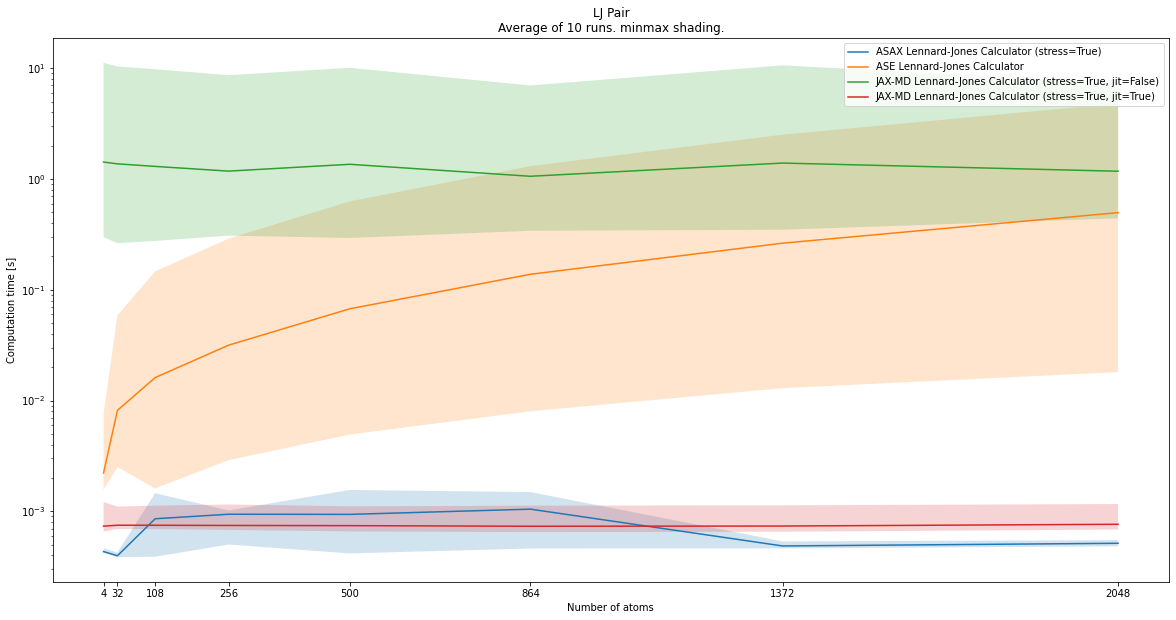

In [234]:
from calculators.lennard_jones.pair.ase_lennard_jones_pair import AseLennardJonesPair
from calculators.lennard_jones.pair.jaxmd_lennard_jones_pair import JmdLennardJonesPair
from calculators.lennard_jones.pair.asax_lennard_jones_pair import AsaxLennardJonesPair

plot_runtimes(results='../results/results.pickle', 
              plot_title='LJ Pair', 
              plot_file_name='plot.png', 
              shade_by='minmax')